In [1]:
import numpy as np
import tensorflow as tf
import sklearn as sk
import sklearn.linear_model as sklm
import sklearn.metrics as skmt
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage.io
import h5py
import sys
import os
import gc

sys.path.append('../Metric/')
sys.path.append('../../Visualization/')
sys.path.append('../../Data_Preprocessing//')
from Metric import *
from Visualization import *
from Data_Extractor import *
from Restored_Classifier import *
from sklearn.externals import joblib

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [13]:
# settings
path_image = "../../Data/Data_in_T/googong_scene.h5"
path_pred_dir = "./Result/Pred/googong"
path_road_mask = "../../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/road_mask.tif"
if not path_pred_dir.endswith('/'): path_pred_dir = path_pred_dir + '/'
    
# sk-SGD_weight_m5_p1_e15_r1  
# sk-SGD_weight_G0.0001_p0_e15_rNone
# Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_p0_e20_r0
classifier_type = 'FCN'
path_model_dir = "../Segmentation-FCN/Result/Inception/Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_p0_e20_r0/"
model_name = "Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_p0_e20_r0"
size = 128
step = 7

path_pred_in_time = path_pred_dir + model_name + '.h5'
print(path_pred_in_time)

use_norm = True
if model_name.find("_G") > 0:
    norm = "Gaussian"
elif model_name.find("_m") > 0:
    norm = "mean"
else:
    norm = None
    use_norm = False

./Result/Pred/googong/Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_p0_e20_r0.h5


In [3]:
# re-load classifier
classifier = Classifier(path_model_dir, model_name, classifier_type)

INFO:tensorflow:Restoring parameters from ../Segmentation-FCN/Result/Inception/Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_p0_e20_r0/Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_p0_e20_r0


In [4]:
# get date list
h5f = h5py.File(path_image, 'r')
date_list = sorted([i for i in h5f['scene'].keys()], key= lambda x:x)
h5f.close()

for date in date_list:

    # check prediction not existing
    h5f = h5py.File(path_pred_in_time, 'a')
    if date in set([pred for pred in h5f.keys()]):
        print(date, 'already predicted, skip')
        h5f.close()
        continue
    else:
        print('predicting', date)
        h5f.close()
    
    # load raw image
    h5f = h5py.File(path_image, 'r')
    raw_image = np.array(h5f['scene'][date])
    h5f.close()
    
    # construct extractor
    data_extractor = Pred_Data_Extractor(raw_image, step=step, size=size,
                                         normalization=norm, classifier_type=classifier_type)
    
    # pred on image
    if classifier_type == 'LR':
        pred_road = np.zeros(shape=raw_image[0].shape)
        print(pred_road.shape, date)

        for coord, patch in data_extractor.iterate_raw_image_patches_with_coord(norm=use_norm):
            pred_road[coord[0]+int(size/2),coord[1]+int(size/2)] = classifier.predict(patch)

    else: # FCN        
        pred_road = np.zeros(shape=(raw_image.shape[1], raw_image.shape[2], 2))
        print(pred_road.shape, date)

        for coord, patch in data_extractor.iterate_raw_image_patches_with_coord(norm=use_norm):
            pred_road[coord[0]:coord[0]+size, coord[1]:coord[1]+size] += classifier.predict(patch)
            
    # save prediction
    h5f = h5py.File(path_pred_in_time, 'a')
    h5f.create_dataset(name=date, data=pred_road)
    h5f.close()

./Result/Pred/googong/Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_p0_e20_r0.h5
predicting 20130520
mu =  [ 304.39495271  410.78889302  631.6269351   839.71987883 2109.82794022
 2388.66369433 1530.64033644]  in  (7, 128, 128)
std =  [148.71138472 172.85423982 235.85833457 309.66714833 496.87213418
 841.246754   589.96485106]  in  (7, 128, 128)
(600, 600, 2) 20130520
predicting 20130621
mu =  [ 299.69643532  396.56635174  601.43120779  779.73365818 1975.67510388
 2264.31871906 1454.47846404]  in  (7, 128, 128)
std =  [155.59614873 177.04041259 237.38591846 304.53028413 512.84547558
 877.43080136 607.55606227]  in  (7, 128, 128)
(600, 600, 2) 20130621
predicting 20130723
mu =  [ 351.60366094  439.90390982  650.82150905  784.76547301 2031.99170163
 2416.8418984  1597.55041453]  in  (7, 128, 128)
std =  [140.96008945 161.64145605 222.77343526 277.54604603 534.20449998
 848.33200304 590.80719719]  in  (7, 128, 128)
(600, 600, 2) 20130723
predicting 20130824
mu =  [ 391.04221255  481.34709

std =  [185.08964742 209.74649119 266.01904306 331.50834647 441.05568717
 631.93288651 481.43629386]  in  (7, 128, 128)
(600, 600, 2) 20151204
predicting 20160206
mu =  [ 377.07657401  475.70113314  749.16371939  851.209371   2436.59206075
 2607.20052923 1696.17691673]  in  (7, 128, 128)
std =  [171.82329408 196.43389639 254.54302344 298.74259486 430.97968219
 676.9298501  497.39101453]  in  (7, 128, 128)
(600, 600, 2) 20160206
predicting 20160325
mu =  [ 383.47156214  474.16324526  712.25272359  832.99187361 2383.91080137
 2586.68729174 1670.9604944 ]  in  (7, 128, 128)
std =  [170.58714488 195.30049246 255.05405626 303.9168782  441.71726752
 792.90539714 563.07631226]  in  (7, 128, 128)
(600, 600, 2) 20160325
predicting 20160410
mu =  [ 393.0302246   497.74576027  736.14950821  916.123224   2365.64515607
 2659.06105533 1735.33360469]  in  (7, 128, 128)
std =  [180.43209122 207.28288509 269.32335917 333.15890707 452.59568793
 879.95902354 624.68343722]  in  (7, 128, 128)
(600, 600, 2)

Analyze pred along the time

In [10]:
def get_patch(coord, mask, size):
    return mask[coord[0]:coord[0]+size, coord[1]:coord[1]+size]

def pred_normalization(pred):
    pred_norm = pred[:,:,1]/pred.sum(axis=-1)
    pred_norm[np.where(pred_norm != pred_norm)] = 0
    pred_norm[np.where(pred_norm == np.float('inf'))] = 1
    return pred_norm

# softmax
def pred_softmax(pred):
    threshold = 500
    pred_exp = pred.copy()
    inf_idx = np.where(pred_exp > threshold)
    
    for x, y in zip(inf_idx[0], inf_idx[1]):
        while((pred_exp[x,y] > threshold).any()):
            pred_exp[x,y] = pred_exp[x,y] / 10
    pred_exp = np.exp(pred_exp[:,:,1])/np.exp(pred_exp).sum(axis=-1)
    pred_exp[np.where(pred[:,:,1] == 0)] = 0 # softmax([0,0]) = (0.5, 0.5)
    return pred_exp

def get_log_pred(pred):
    log_pred = -np.log(-pred + 1 + 1e-9)
    norm_log_pred = (log_pred - log_pred.min()) / (log_pred.max()-log_pred.min())
    return norm_log_pred

#######################################################

def load_raw_and_pred(path_image, path_pred_in_time, date, classifier_type):
    # load prediction 
    h5f = h5py.File(path_pred_in_time, 'r')
    pred_road = np.array(h5f[date])
    h5f.close()
    
    if classifier_type == 'FCN':
        pred_road = pred_normalization(pred_road)

    # load raw image
    h5f = h5py.File(path_image, 'r')
    raw_image = np.array(h5f['scene'][date])
    h5f.close()
    
    return raw_image, pred_road
    
def time_diff(img_old, img_new):
    img_diff = img_new - img_old
    if len(img_diff.shape) == 2:
        img_diff = (img_diff - img_diff.min()) / (img_diff.max() - img_diff.min())
    else:
        for band_idx in range(img_diff.shape[0]):
            img_diff[band_idx] = (img_diff[band_idx] - img_diff[band_idx].min()) / (img_diff[band_idx].max() - img_diff[band_idx].min())
    
    img_diff[np.where(img_diff != img_diff)] = 0    
    return img_diff

In [11]:
# load road mask
h5f = h5py.File(path_image, 'r')
road_mask = np.array(h5f['road'])
h5f.close()

# get date list
h5f = h5py.File(path_image, 'r')
date_list = sorted([i for i in h5f['scene'].keys()], key= lambda x:x)
h5f.close()

# get sample raw image
h5f = h5py.File(path_image, 'r')
raw_image = np.array(h5f['scene'][date_list[0]])
h5f.close()

gc.collect()

543

normalizing pred -  20130520


/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


normalizing pred -  20130621
normalizing pred -  20130723
normalizing pred -  20130824
normalizing pred -  20130909
normalizing pred -  20131011
normalizing pred -  20131230
normalizing pred -  20140115
normalizing pred -  20140131
normalizing pred -  20140216
normalizing pred -  20140320
normalizing pred -  20140507
normalizing pred -  20140710
normalizing pred -  20140726
normalizing pred -  20140811
normalizing pred -  20140827
normalizing pred -  20140928
normalizing pred -  20141030
normalizing pred -  20141217
normalizing pred -  20150102
normalizing pred -  20150307
normalizing pred -  20150408
normalizing pred -  20150611
normalizing pred -  20150713
normalizing pred -  20150729
normalizing pred -  20150830
normalizing pred -  20150915
normalizing pred -  20151001
normalizing pred -  20151204
normalizing pred -  20160206
normalizing pred -  20160325
normalizing pred -  20160410
normalizing pred -  20160426
normalizing pred -  20160512
normalizing pred -  20160613
normalizing pr

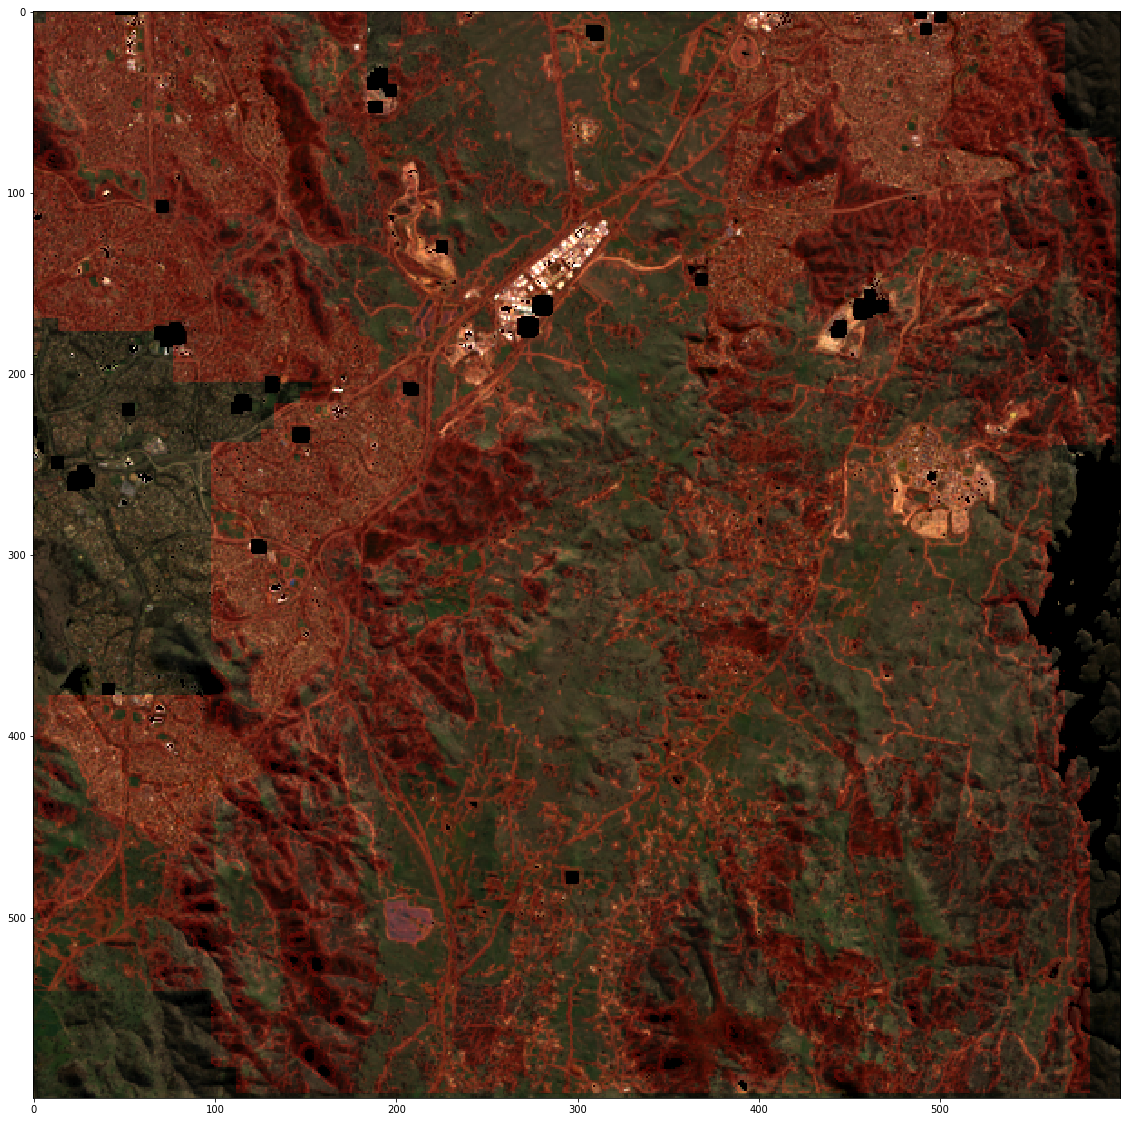

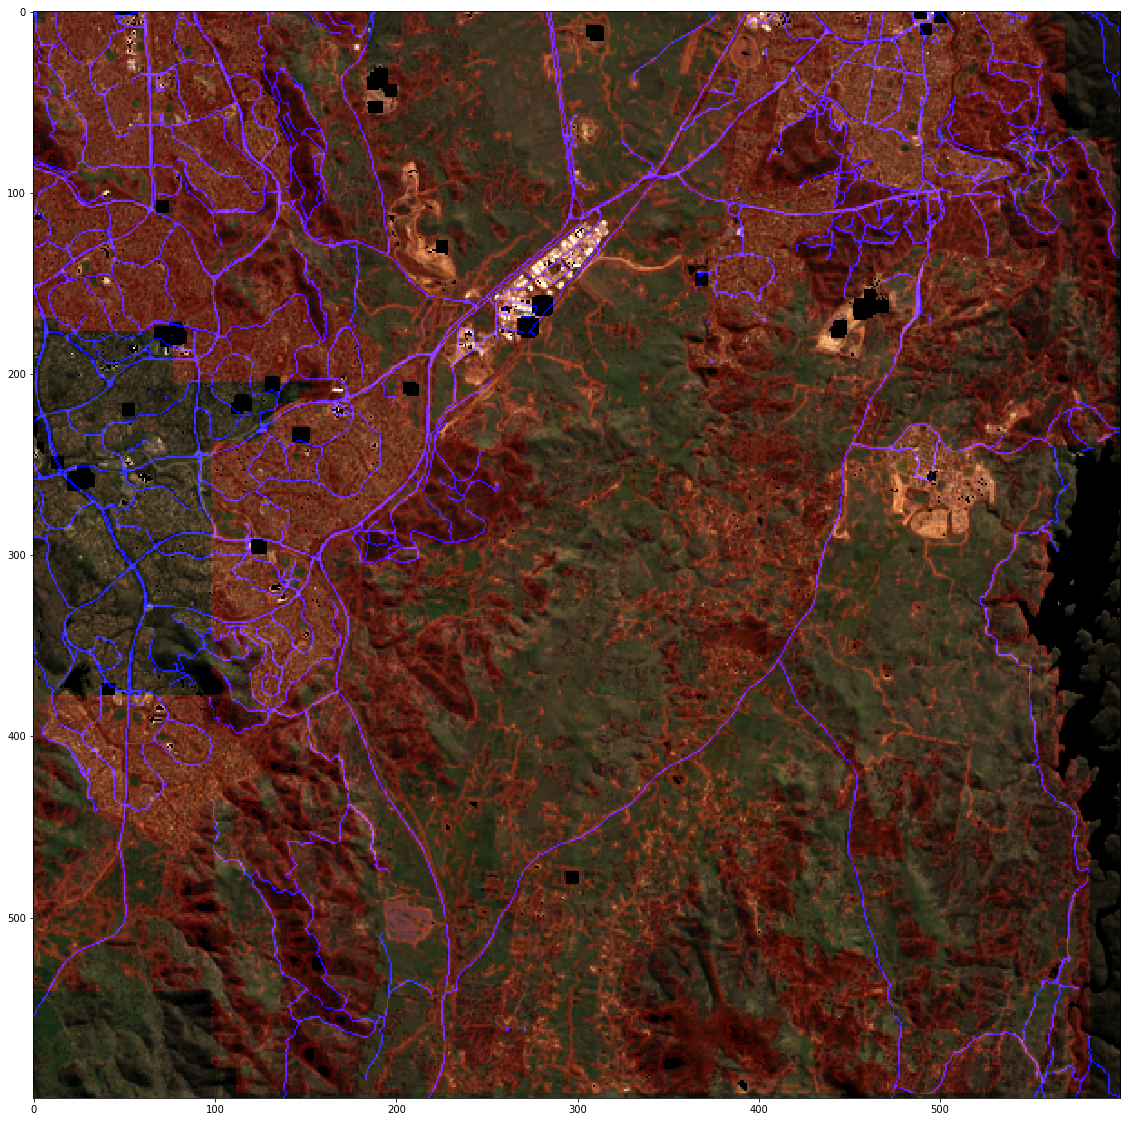

In [7]:
# visualise prediction

for date in date_list:

    # load prediction 
    h5f = h5py.File(path_pred_in_time, 'r')
    pred_road = np.array(h5f[date])
    h5f.close()
    
    # load raw image
    h5f = h5py.File(path_image, 'r')
    raw_image = np.array(h5f['scene'][date])
    h5f.close()
    
    if classifier.classifier_type == 'FCN':
        print('normalizing pred - ', date)
        pred_road = pred_normalization(pred_road)
        
    plt.close('all')
    
    plt.figure(figsize=(20,20))
    
    road_mask_RGB = np.zeros(shape=list(road_mask.shape) + [3])
    road_mask_RGB[:,:,0] = road_mask_RGB[:,:,0] + pred_road # pred in R channel
    road_mask_RGB[:,:,2] = road_mask_RGB[:,:,2] + road_mask # true in B channel
    plt.imshow(road_mask_RGB)
    plt.savefig(path_pred_dir+'road_pred/'+date)
    plt.close()

    plt.figure(figsize=(20,20))
    plt.imshow(pred_road)
    plt.savefig(path_pred_dir+'only_pred/'+date)
    plt.close()
    
    show_pred_prob_with_raw(raw_image, pred_road, size=-1, figsize=(20,20), 
                            show_plot=False, save_path=path_pred_dir+'raw_pred/'+date)
    
    show_pred_prob_with_raw(raw_image, pred_road, road_mask, size=-1, figsize=(20,20), 
                            show_plot=False, save_path=path_pred_dir+'raw_pred_with_road/'+date)
    

In [24]:
# denoising - time diff

plt.close('all')
for date_old, date_new in zip(date_list, date_list[1:]):
    
    print(date_old, date_new)
    
    raw_old, pred_old = load_raw_and_pred(path_image, path_pred_in_time, date_old, classifier.classifier_type)
    raw_new, pred_new = load_raw_and_pred(path_image, path_pred_in_time, date_new, classifier.classifier_type)

    pred_diff = time_diff(pred_old, pred_new)
    raw_diff  = time_diff(raw_old, raw_new)

    plt.figure(figsize=(20,20))
    plt.imshow(pred_diff)
    plt.savefig(path_pred_dir+'pred_diff/' + date_old+'-'+date_new)
    plt.close()

20130520 20130621


/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


20130621 20130723
20130723 20130824
20130824 20130909
20130909 20131011
20131011 20131230
20131230 20140115
20140115 20140131
20140131 20140216
20140216 20140320
20140320 20140507


/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in short_scalars


20140507 20140710
20140710 20140726
20140726 20140811
20140811 20140827
20140827 20140928
20140928 20141030
20141030 20141217
20141217 20150102
20150102 20150307
20150307 20150408
20150408 20150611
20150611 20150713
20150713 20150729
20150729 20150830
20150830 20150915
20150915 20151001
20151001 20151204
20151204 20160206
20160206 20160325
20160325 20160410
20160410 20160426
20160426 20160512
20160512 20160613
20160613 20160715
20160715 20161104
20161104 20161120
20161120 20161206
20161206 20161222
20161222 20170208
20170208 20170312
20170312 20170328
20170328 20170413
20170413 20170429
20170429 20170515
20170515 20170531


/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


42392 nan
40873 nan
41510 nan
41202 nan
40565 nan


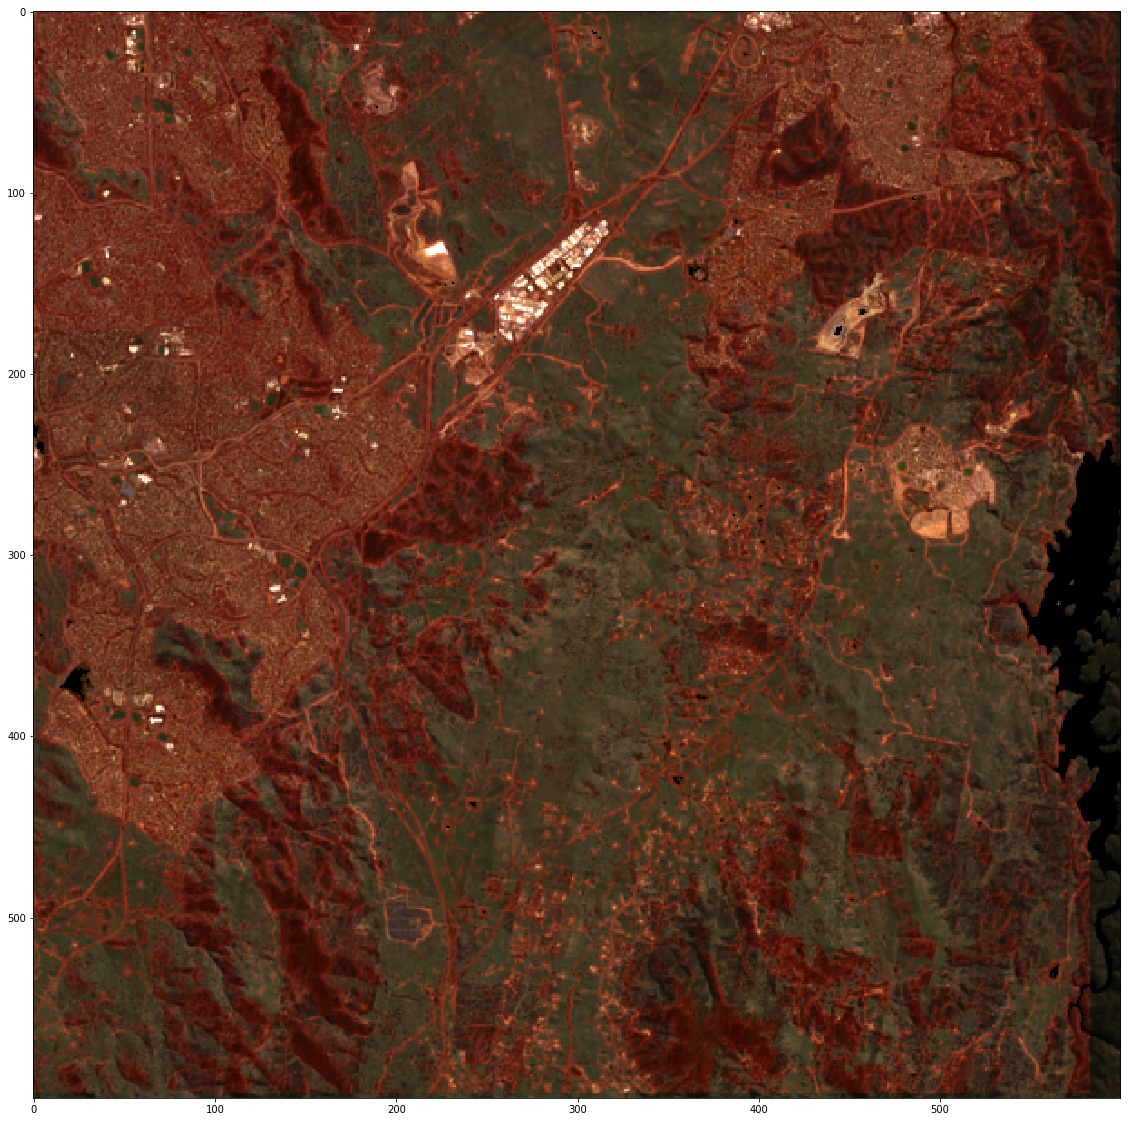

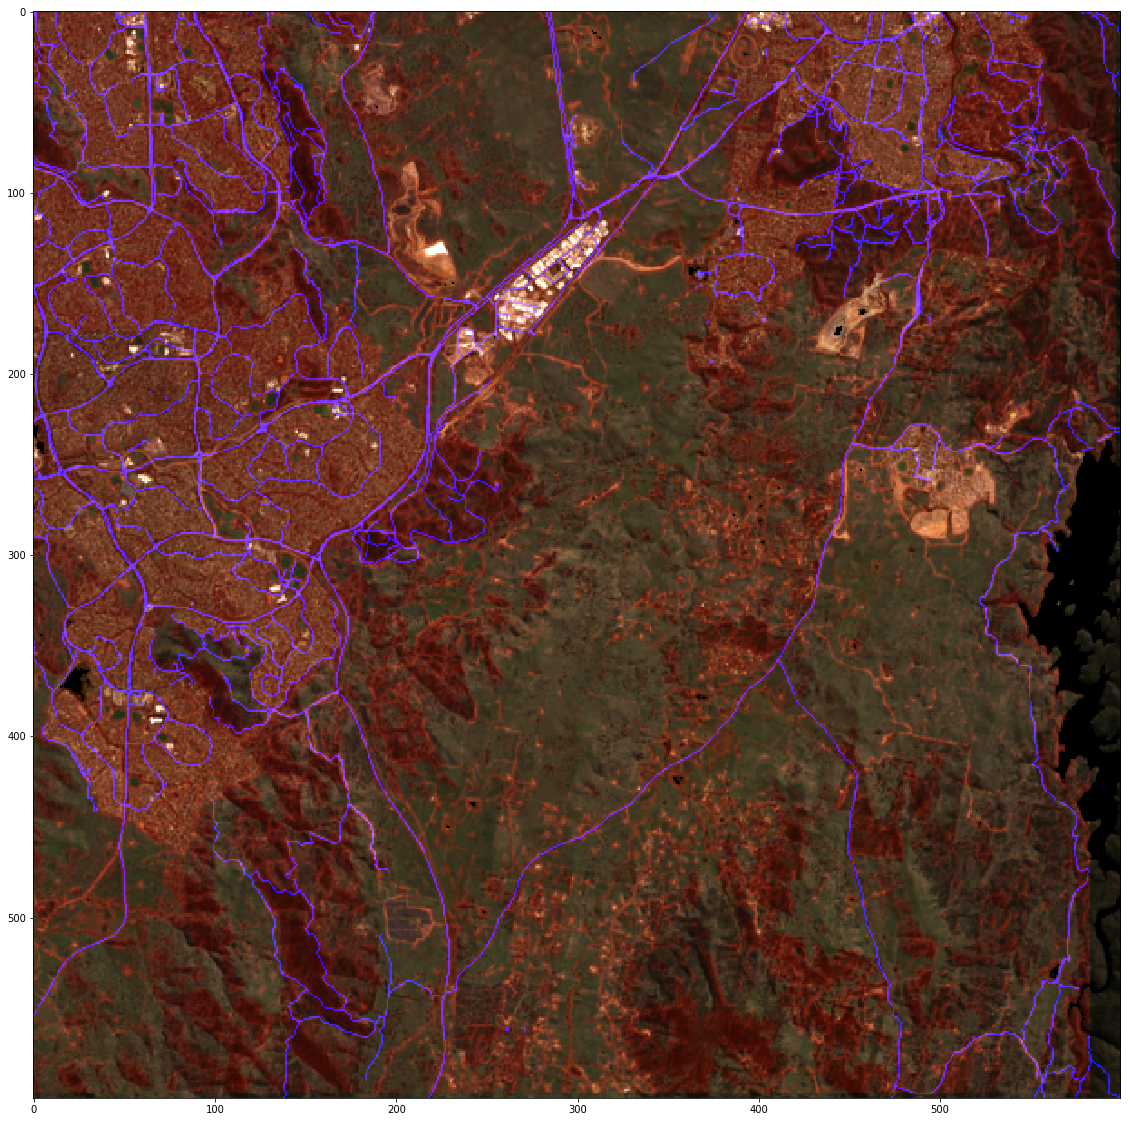

In [53]:
# denoising - time average
raw_shape  = raw_image.shape
road_shape = road_mask.shape

for year in [2013,2014,2015,2016,2017]:
    year = str(year)
    
    valid_road_cnt = np.zeros(shape=road_shape)
    pred_road = np.zeros(shape=road_shape)
    valid_raw_cnt = np.zeros(shape=raw_shape)
    raw_image = np.zeros(shape=raw_shape)
    
    for date in date_list:
        if year not in date: continue
        
        cur_raw, cur_pred = load_raw_and_pred(path_image, path_pred_in_time, date, classifier_type)
        
        valid_idx = np.where(cur_raw[0] != -9999)
        valid_road_cnt[valid_idx] = valid_road_cnt[valid_idx] + 1        
        pred_road[valid_idx] = pred_road[valid_idx] + cur_pred[valid_idx]
        
        valid_idx = np.where(cur_raw != -9999)
        valid_raw_cnt[valid_idx] = valid_raw_cnt[valid_idx] + 1
        raw_image[valid_idx] = raw_image[valid_idx] + cur_raw[valid_idx]
        gc.collect()
    
    pred_road = pred_road/valid_road_cnt
    raw_image = raw_image/valid_raw_cnt

    invalid_idx = np.where(valid_road_cnt == 0)
    pred_road[invalid_idx] = 0
    invalid_idx = np.where(valid_raw_cnt == 0)
    print((valid_raw_cnt == 0).sum(), raw_image.min())
    raw_image[invalid_idx] = -9999
    
    plt.close('all')
    plt.figure(figsize=(20,20))
    plt.imshow(pred_road)
    plt.savefig(path_pred_dir+'only_pred/'+year)
    plt.close('all')    
    
    show_pred_prob_with_raw(raw_image, pred_road, size=-1, figsize=(20,20), 
                            show_plot=False, save_path=path_pred_dir+'raw_pred/'+year)
    
    show_pred_prob_with_raw(raw_image, pred_road, road_mask, size=-1, figsize=(20,20), 
                            show_plot=False, save_path=path_pred_dir+'raw_pred_with_road/'+year)        

In [28]:
date_old = '20130621'
date_new = '20170531'    
print(date_old, date_new)

raw_old, pred_old = load_raw_and_pred(path_image, path_pred_in_time, date_old, classifier.classifier_type)
raw_new, pred_new = load_raw_and_pred(path_image, path_pred_in_time, date_new, classifier.classifier_type)

pred_diff = time_diff(pred_old, pred_new)
raw_diff  = time_diff(raw_old, raw_new)

#     show_pred_prob_with_raw(raw_diff, pred_diff, size=-1, figsize=(20,20), 
#                         show_plot=False, save_path=path_pred_dir+'pred_diff/' + date_old+'-'+date_new)

#     road_mask_RGB = np.zeros(shape=list(road_mask.shape) + [3])
#     road_mask_RGB[:,:,0] = road_mask_RGB[:,:,0] + pred_road # pred in R channel
#     road_mask_RGB[:,:,2] = road_mask_RGB[:,:,2] + road_mask # true in B channel
#     plt.imshow(road_mask_RGB)
#     plt.savefig(path_pred_dir+'road_pred/'+date)
#     plt.close()

plt.figure(figsize=(20,20))
plt.imshow(pred_diff)
plt.savefig(path_pred_dir+'pred_diff/' + date_old+'-'+date_new)
plt.close()
    


20130621 20170531


/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [ ]:
# plot proba by date
plt.figure(figsize=(20, 20))
for row, coord in zip((sorted_road.T), coord_list):
    valid_row = row[np.where(row == row)]
    
    # ensure the probability increase
    if len(valid_row) > 0 and (np.diff(valid_row) >= 0).all() and (np.diff(valid_row) > 0).any():
        plt.plot(row, label=str(coord))
        
plt.legend()
plt.show()
plt.close()

In [ ]:
appearing_road_coord_list = []
for row, coord in zip((sorted_road.T), coord_list):
    valid_row = row[np.where(row == row)]
    
    # ensure the probability increase
    if len(valid_row) > 0 and (np.diff(valid_row) >= 0).all() and (np.diff(valid_row) > 0).any():
        appearing_road_coord_list.append(coord)
        
print(len(appearing_road_coord_list), set(appearing_road_coord_list))

In [ ]:
nrows = len(appearing_road_coord_list)
ncols = len(image_list)
print(nrows, ncols)

plt.close('all')
plt.figure(figsize=(60,240))

# from 2014 to 2017
for image_name, index in zip(sorted(image_list), range(1,nrows+1)):
    
    # restore prediction 
    date = image_name.split('.')[0].split('_')[-1]
    h5f = h5py.File(path_pred_in_time, 'r')
    pred_road = np.array(h5f[date])
    h5f.close()

    # load raw image
    image_path = path_image_dir + image_name
    h5f = h5py.File(image_path, 'r')
    raw_image = np.array(h5f['scene'])
    h5f.close()
    
    gc.collect()
    
    # plot the scene in current date
    for coord in appearing_road_coord_list:
        plt.title(str(date) + ',' + str(coord))
        plt.subplot(nrows, ncols, index)
        show_pred_prob_with_raw(raw_image, pred_road, true_road=road_mask, 
                                coord=coord, size=block_size, show_plot=False)
        index += ncols

plt.savefig('changing_road')
plt.show()
        

In [ ]:
plt.close('all')
gc.collect()

In [ ]:
road_proba_divide = {}
divide_num = 4
step_size = int(block_size/divide_num)

for image_name in image_list:
    gc.collect()

    # restore prediction 
    date = image_name.split('.')[0].split('_')[-1]
    h5f = h5py.File(path_pred_in_time, 'r')
    pred_road = np.array(h5f[date])
    h5f.close()

    # load raw image
    image_path = path_image_dir + image_name
    h5f = h5py.File(image_path, 'r')
    raw_image = np.array(h5f['scene'])
    h5f.close()

    assert not (date in road_proba_divide)
    
    for coord in coord_list:
        for offset_x in range(divide_num):
            offset_x *= step_size

            for offset_y in range(divide_num):
                offset_y *= step_size
                
                coord[0] += offset_x
                coord[1] += offset_y
                
                sub_valid_mask = (get_patch(coord, raw_image[0], step_size) != -9999)
                sub_road_mask  = (get_patch(coord, road_mask, block_size) == 1)
                sub_valid_road_mask = np.logical_and(sub_valid_mask, sub_road_mask)
                
                if sub_valid_road_mask.sum() / np.prod(sub_valid_road_mask.shape) <  1/100:
                    

In [ ]:
sub_valid_road_mask.sum() / np.prod(sub_valid_road_mask.shape) < 1/100


In [ ]:
# load road mask
road_mask = skimage.io.imread(path_road_mask)
road_proba = {}

for image_name in image_list:
    gc.collect()

    # restore prediction 
    date = image_name.split('.')[0].split('_')[-1]
    h5f = h5py.File(path_pred_in_time, 'r')
    pred_road = np.array(h5f[date])
    h5f.close()

    # load raw image
    image_path = path_image_dir + image_name
    h5f = h5py.File(image_path, 'r')
    raw_image = np.array(h5f['scene'])
    h5f.close()
    
    # construct extractor
    data_extractor = Pred_Data_Extractor(raw_image, step=block_size, size=block_size,
                                         normalization=None, is_valid=lambda patch: True)
    assert not (date in road_proba)
    road_proba[date] = {}
    for coord, patch in data_extractor.iterate_raw_image_patches_with_coord(norm=False):
        sub_valid_mask = patch[0][0] != -9999
        sub_road_mask  = get_patch(coord, road_mask, block_size) == 1
        sub_valid_road_mask = np.logical_and(sub_valid_mask, sub_road_mask)
        
        assert not (coord in road_proba[date])
        mean_prob = get_patch(coord, pred_road, block_size)[np.where(sub_valid_road_mask)].mean()
        if mean_prob != mean_prob:
            mean_prob = 0
        road_proba[date][coord] = mean_prob

Analyze log pred

In [ ]:
log_pred = -np.log(-pred_road + 1 + 1e-7)
print(log_pred.min(), log_pred.max(), log_pred.mean())

norm_log_pred = (log_pred - log_pred.min()) / (log_pred.max()-log_pred.min())
print(norm_log_pred.min(), norm_log_pred.max(), norm_log_pred.mean())

plt.hist(x=norm_log_pred.flatten(), bins=100, histtype='step')
plt.show()
plt.close()
plt.hist(x=norm_log_pred[np.where(norm_log_pred>0)].flatten(), bins=100, histtype='step')
plt.show()
plt.close()

In [ ]:
path_road = "../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/road_mask.tif"
road_mask = skimage.io.imread(path_road)

In [ ]:
show_pred_road_against_raw(raw_image, norm_log_pred, road_mask, threshold=0.40, figsize=(150,150), show_plot=False,
                        save_path="123")
gc.collect()

In [ ]:
plt.imshow(np.array([[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]]), cmap='hot')
plt.show()
plt.figure(figsize=(100,100))
plt.imshow(pred_road, cmap=plt.get_cmap('hot'))
plt.show()
plt.close()

In [ ]:
plt.imshow(np.array([[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]]), cmap='hot')
plt.show()
plt.figure(figsize=(100,100))
plt.imshow(np.log(pred_road + 1e-9), cmap='hot')
plt.show()
plt.close()